Vamos a intentar entender (aproximadamente) cuántos puntos de lc se necesitan para una estimación correcta del período.

# Código Auxiliar

## Imports
Pongo los imports acá porque no discutimos organización de código.

In [1]:
import carpyncho
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Manipulación de curvas de luz

In [3]:
from light_curve_sampler import LightCurveSampler

# Deterioro del Período

## Obtención de los datos
Primero descargamos el tile `b278` porque es el tile favorito de Pablo. Chequeamos qué tipos de estrellas periódicas están clasificados.

In [4]:
# Instance the client and get the b278 tile catalogs.
client = carpyncho.Carpyncho()
b278_lc = client.get_catalog("b278", "lc")
b278_features = client.get_catalog("b278", "features")
b278_features.vs_type.unique()

<StringArray>
[           '',      'ECL-NC',  'RRLyr-RRab',   'LPV-OSARG',       'ECL-C',
     'LPV-SRV',   'RRLyr-RRc',     'ECL-ELL',    'LPV-Mira', 'T2Cep-BLHer',
       'CV-DN', 'T2Cep-RVTau',  'T2Cep-WVir',   'RRLyr-RRd',    'SP_ECL-C',
   'SP_ECL-NC',        'BLAP',       'Cep-1',       'Cep-F']
Length: 19, dtype: string

Todas las clasificadas son periódicas.

In [5]:
b278_features = b278_features[b278_features["vs_type"] != ""]
# periodic_star_types = ["RRLyr-RRab", "RRLyr-RRc", "RRLyr-RRd"]
# b278_features = b278_features[b278_features["vs_type"].isin(periodic_star_types)]
b278_lc = b278_lc[b278_lc.bm_src_id.isin(b278_features.id.to_numpy())]

In [31]:
b278_lc

,bm_src_id,pwp_stack_src_hjd,pwp_stack_src_mag3,pwp_stack_src_mag_err3
2198,32780000130429,56559.002017,14.790,0.064
2200,32780000131392,56559.002010,14.591,0.054
2930,32780000135858,56559.002009,14.367,0.044
3962,32780000143258,56559.002013,14.591,0.054
4973,32780000149862,56559.002012,14.278,0.041
...,...,...,...,...
94459199,32780000930947,56506.997219,15.590,0.100
94459280,32780000931758,56506.997215,14.824,0.051
94465182,32780000846846,56506.997229,15.526,0.091
94474936,32780000906990,56506.997227,13.995,0.023


In [32]:
b278_features

,id,cnt,ra_k,dec_k,vs_type,vs_catalog,Amplitude,Autocor_length,Beyond1Std,Con,...,c89_jk_color,c89_m2,c89_m4,n09_c3,n09_hk_color,n09_jh_color,n09_jk_color,n09_m2,n09_m4,ppmb
479,32780000002917,58,270.797217,-30.889178,RRLyr-RRab,OGLE-4,0.24850,1.0,0.344828,0.0,...,0.332137,14.842291,14.828564,0.064841,0.098619,0.235392,0.334011,14.996892,14.998764,0.463381
1244,32780000005228,114,270.753125,-30.863844,RRLyr-RRab,OGLE-3,0.14950,1.0,0.333333,0.0,...,0.300861,13.753861,13.732589,0.146753,0.057082,0.245498,0.302581,13.898376,13.902603,1.847552
4478,32780000008400,57,270.224575,-30.600756,RRLyr-RRab,OGLE-4,0.27250,1.0,0.298246,0.0,...,0.183028,14.295380,14.289170,0.014729,0.062195,0.122289,0.184484,14.394760,14.395185,1.779271
4761,32780000008729,101,270.753467,-30.856761,RRLyr-RRc,vizier,0.10825,1.0,0.297030,0.0,...,0.189860,14.549579,14.542438,0.013916,0.065082,0.126499,0.191580,14.670846,14.671247,5.363732
7551,32780000012434,53,270.179458,-30.570828,RRLyr-RRc,OGLE-4,0.09450,1.0,0.339623,0.0,...,0.062325,14.575846,14.545831,0.271018,-0.076004,0.139781,0.063777,14.651218,14.659138,0.004794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857039,32780000930947,111,271.738038,-29.672497,RRLyr-RRab,OGLE-4,0.28950,1.0,0.288288,0.0,...,0.103729,15.723726,15.715780,0.050498,0.019842,0.084742,0.104585,15.787393,15.788875,2.147714
857795,32780000931758,77,271.650196,-29.630828,RRLyr-RRc,vizier,0.12250,1.0,0.324675,0.0,...,0.115026,14.596278,14.576428,0.171289,-0.020356,0.136235,0.115878,14.663503,14.668616,2.998110
858834,32780000932872,90,271.846892,-29.721153,RRLyr-RRab,OGLE-3,0.26700,2.0,0.255556,0.0,...,0.162770,14.306237,14.282974,0.197985,-0.012630,0.175940,0.163310,14.377789,14.383087,0.270734
863839,32780000938199,57,271.002996,-29.305242,RRLyr-RRab,OGLE-4,0.17150,1.0,0.210526,0.0,...,0.212238,13.837621,13.826073,0.077380,0.049973,0.163542,0.213515,13.921748,13.924036,0.180505


La meto en mi clase.

In [6]:
star = b278_features.loc[b278_features["cnt"].idxmax()]
# Get the observations for the star.
light_curve = b278_lc[b278_lc.bm_src_id == star.id]

lc = LightCurveSampler(light_curve, star.PeriodLS)

Para cada cantidad de observaciones entre `min_obs` y la total disponible, buscamos el período.

In [7]:
def get_period_list(lc: LightCurveSampler):
    period_list = []
    size_list = []

    for n_sample in range(len(light_curve), 30, -1):
        lc.subsample(n_sample)
        period, _ = lc.calculate_period()
        period_list.append(period)
        size_list.append(n_sample)

    return size_list, period_list

A graficar!

In [8]:
def plot_periods(size_list, period_list):
    plt.plot(size_list, period_list, color="tab:blue", label="periodo calculado")
    plt.axhline(y=star.PeriodLS, color="tab:orange", label="periodo del catalogo")
    plt.xlabel("cantidad de observaciones")
    plt.ylabel("periodo")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
lc_size, lc_period = get_period_list(lc)

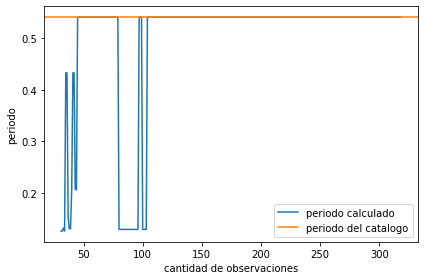

In [10]:
plot_periods(lc_size, lc_period)

# Resultados

(array([  0.,  58., 113.,  60.,  42.,  40.,  21.,  12.,  12.,  19.,  23.,
         21.,   1.,   2.,   1.,   1.,   6.,   0.,   2.,   2.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([  0.        ,  10.34482759,  20.68965517,  31.03448276,
         41.37931034,  51.72413793,  62.06896552,  72.4137931 ,
         82.75862069,  93.10344828, 103.44827586, 113.79310345,
        124.13793103, 134.48275862, 144.82758621, 155.17241379,
        165.51724138, 175.86206897, 186.20689655, 196.55172414,
        206.89655172, 217.24137931, 227.5862069 , 237.93103448,
        248.27586207, 258.62068966, 268.96551724, 279.31034483,
        289.65517241, 300.        ]),
 <BarContainer object of 29 artists>)

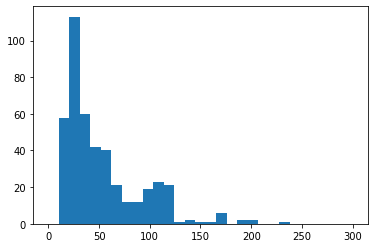

In [30]:
clipped_df = pd.read_csv("clipping_obs_threshold.csv")
# ax = sns.kdeplot(data=clipped_df, x="obs_threshold", hue="vs_type")
x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()


plt.hist(clipped_df.obs_threshold.values, bins=np.linspace(0, 300, 30))

(array([ 245.,  617., 1058.,  651., 1459., 1963.,  159.,  433.,   41.]),
 array([  0.        ,  22.22222222,  44.44444444,  66.66666667,
         88.88888889, 111.11111111, 133.33333333, 155.55555556,
        177.77777778, 200.        ]),
 <BarContainer object of 9 artists>)

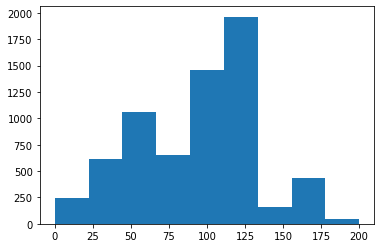

In [7]:
tile = "b278"
snr20_df = pd.read_csv(f"min_obs_{tile}_snr20.csv")
plt.hist(snr20_df.obs_threshold.values, bins=np.linspace(0, 200, 10))

/home/gianni/.virtualenvs/Tesina/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/gianni/.virtualenvs/Tesina/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


27.60166268527861

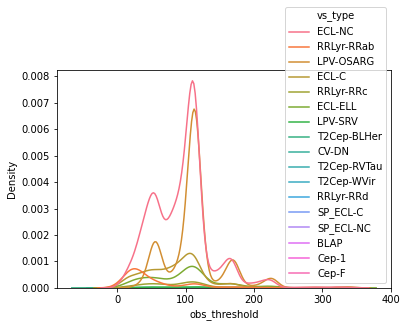

In [9]:
ax = sns.kdeplot(data=snr20_df, x="obs_threshold", hue="vs_type")
# x = ax.lines[0].get_xdata()
# y = ax.lines[0].get_ydata()
# x[y.argmax()]